In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import random
from ipyleaflet import Map, Circle
import seaborn as sns
sns.set()
from IPython.display import display

Using TensorFlow backend.


In [2]:
def min_max_normalize(series):
    return (series - series.min()) / (series.max()-series.min())

def addPoint(map, lat, lng, isMatch, predicted_match=None):
    if not (predicted_match is None) and predicted_match != isMatch:
        color = '#f44'
    else:
        color = '#44F' if isMatch else '#999'
        
    map.add_layer(Circle(location=[lat, lng], radius=8, color=color, opacity=.7, fill_opacity=.7, fill_color=color))

# Prepare the Data

In [3]:
raw_df = pd.read_csv('places.csv')
#shuffel the places
raw_df = raw_df.sample(frac=0.4).reset_index(drop=True)

## Generate more data
# for index, row in raw_df.iterrows():
#     for i in range(4):
#         raw_df.loc[len(raw_df)] = [
#             row['lat'] + random.uniform(-2/100000, 2/100000),
#             row['lng'] + random.uniform(-2/100000, 2/100000),
#             row['heading'] + random.uniform(-1, 1),
#             row['isMatch']
#         ]

df = min_max_normalize(raw_df)

#df['notMatch'] = [int (not isMatch) for isMatch in df['isMatch']]
inputMatrix = df[['lat', 'lng', 'heading']].as_matrix()
target = df['isMatch'].as_matrix()

df.describe()

,lat,lng,heading,isMatch
count,67.000000,67.000000,67.000000,67.000000
mean,0.483294,0.509569,0.251447,0.238806
std,0.297381,0.298536,0.315096,0.429572
min,0.000000,0.000000,0.000000,0.000000
25%,0.196109,0.281290,0.000000,0.000000
50%,0.491639,0.510698,0.146824,0.000000
75%,0.715474,0.753751,0.230694,0.000000
max,1.000000,1.000000,1.000000,1.000000


# Visualize the Data

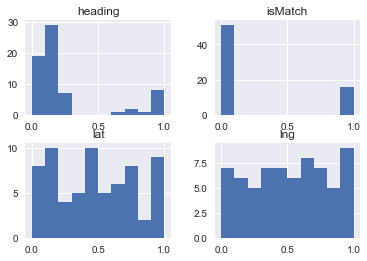

Widget Javascript not detected.  It may not be installed or enabled properly.


In [4]:
df.hist()
plt.show()

map = Map(center=[raw_df.lat.mean(), raw_df.lng.mean()], zoom=17)

for index, row in raw_df.iterrows():
    addPoint(map, lat=row.lat, lng=row.lng, isMatch=row.isMatch)

map

# Train the Model

In [5]:
def get_model():
    model = Sequential()
    model.add(Dense(30, input_dim=len(inputMatrix[0]), activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

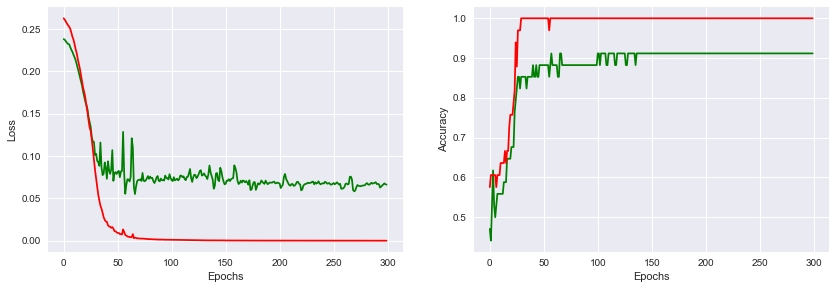

Accuracy: 91.18%


In [6]:
model = get_model()

weights = {0: df.isMatch.mean(), 1: (1 - df.isMatch.mean())}

training_data = model.fit(inputMatrix, target, validation_split=0.5, epochs=300, batch_size=4, class_weight=weights, verbose=False)

fig, axis = plt.subplots(1,2)
fig.set_size_inches(14, 4.5)
axis[0].plot(training_data.history['val_loss'], 'g', training_data.history['loss'], 'r')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[1].plot(training_data.history['val_acc'], 'g', training_data.history['acc'], 'r')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
plt.show()

print('Accuracy: %.2f%%' % (training_data.history['val_acc'][-1]*100))

# Measure Performance
K-Fold Cross Validation

In [7]:
estimator = KerasClassifier(build_fn=get_model, epochs=200, batch_size=10, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, inputMatrix, target, cv=kfold)
print('Accuracy: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Accuracy: 95.79% (5.45%)


# Visualize the Model

In [8]:
map = Map(center=[raw_df.lat.mean(), raw_df.lng.mean()], zoom=17)

for index, input_row in enumerate(inputMatrix):
    predicted_match = model.predict(np.array([input_row])) > 0.5;
    raw_row = raw_df.loc[index]
    addPoint(map, lat=raw_row.lat, lng=raw_row.lng, isMatch=raw_row.isMatch, predicted_match=predicted_match)

map

Widget Javascript not detected.  It may not be installed or enabled properly.
